In [20]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

In [21]:
def normalize_data(img, by):
    return np.array(img)/by
    
def load_custom_data(img_dir, shape, batch_size, rgb=True):
    w, h, alpha = shape
    temp_shape = list(shape)
    temp_shape.insert(0, batch_size)
    temp_shape = tuple(temp_shape)
    
    faces = os.listdir(img_dir)
    
    if len(faces) < 2:
        print('There should at least two person images in the train directory!!!')
        return
        
    person_select = np.random.choice(len(faces))
    person_dir = img_dir + faces[person_select]
    
    pairs = [np.zeros(temp_shape) for i in range(2)]
    targets = np.zeros((batch_size, ))
    targets[batch_size//2:] = 1
    
    for i in range(batch_size):
        person_faces = os.listdir(person_dir)
        pairs[0][i, :, :] = normalize_data(load_img(
            os.path.join(person_dir, np.random.choice(person_faces)),
            color_mode='grayscale', 
            target_size=(w, h)
        ), 255).reshape(shape)
        
        
        if i >= batch_size//2:
            pairs[1][i, :, :] = normalize_data(load_img(
                os.path.join(person_dir, np.random.choice(person_faces)),
                color_mode='grayscale',
                target_size=(w, h),
            ), 255).reshape(shape)
        else:
            new_person_select = (person_select  + np.random.randint(1, len(faces))) % len(faces)
            new_person_dir = img_dir +faces[new_person_select]
            new_person_faces = os.listdir(new_person_dir)
            pairs[1][i, :, :] = normalize_data(load_img(
                os.path.join(new_person_dir, np.random.choice(new_person_faces)),
                color_mode='grayscale',
                target_size=(w, h)
            ), 255).reshape(shape)
    return pairs, targets

In [22]:
load_custom_data('./dataset/train/', (64, 64, 1), 20, False)

There should at least two person images in the train directory!!!


In [23]:
def generate_custom_data(img_dir, shape, batch_size):
    while(True):
        pairs, target = load_custom_data(img_dir, shape, batch_size)
        yield(pairs, target)

In [24]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Lambda
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from tensorflow import abs

def get_siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(64, (6, 6), activation='relu', input_shape=input_shape))

    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4, 4), activation='relu'))

    model.add(MaxPooling2D())
    model.add(Conv2D(128, (2, 2), activation='relu'))

    model.add(MaxPooling2D())
    model.add(Conv2D(256, (2, 2), activation='relu'))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))

    model_left = model(left_input)
    model_right = model(right_input)

    output_layer = Lambda(lambda x: abs(x[0] - x[1]))
    distance = output_layer([model_left, model_right])

    prediction = Dense(1, activation='sigmoid')(distance)

    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    return siamese_net


In [25]:
model = get_siamese_model((64, 64, 1))
optimizer = tf.optimizers.Adam(lr=2*1e-4) 
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         26549056    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

In [27]:
model.fit(
    generate_custom_data('./dataset/train/', (64, 64, 1), 300),
    epochs=5,
    steps_per_epoch=300,
    validation_data=generate_custom_data('./dataset/train/',(64, 64, 1), 50),
    validation_steps=50
)

Epoch 1/5


KeyboardInterrupt: 

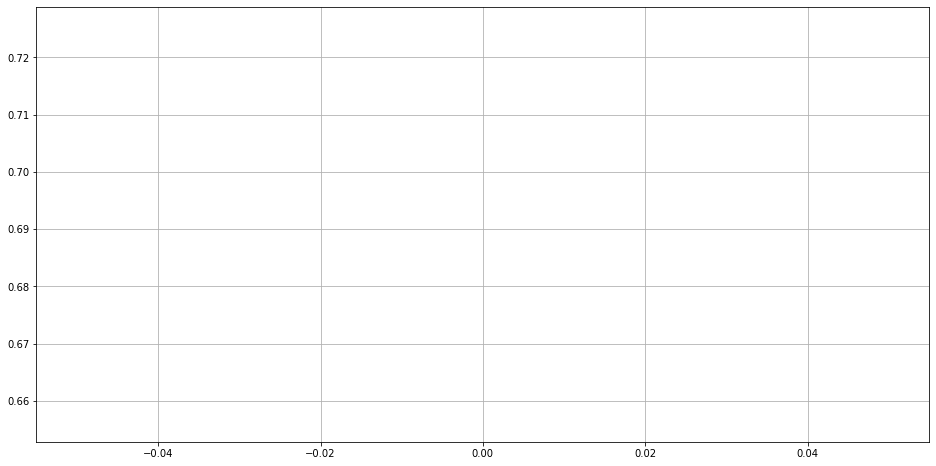

In [22]:
plt.figure(figsize=(16, 8))
epochs = list(range(len(model.history.history['loss'])))
loss = model.history.history['loss']
plt.plot(epochs, loss)
plt.grid()

In [23]:
def compare_imgs(cap_img, img_dir, rgb=True):
    persons = os.listdir(img_dir)
    confidences = []
    for person in persons:
        faces = os.listdir(os.path.join(img_dir, person))
        confidence = 0
        for i in range(5):            
            choosen_face_path = os.path.join(img_dir, person, np.random.choice(faces))
            choosen_face_img = normalize_data(load_img(
                choosen_face_path,
                color_mode='grayscale' if not rgb else 'rgb', 
                target_size=(64, 64)
            ), 255)
            reshape = (-1, 64, 64, 1) if not rgb else (-1, 64, 64, 3)
            confidence += model.predict([cap_img.reshape(reshape), choosen_face_img.reshape(reshape)])[0][0]
        confidence = np.round(confidence/5, 4)
        confidences.append(confidence)
    
    if np.max(confidences) > 0.5:
        print(f'testing\n{persons}\n{confidences}')
        return (persons[np.argmax(confidences)], str(np.max(confidences)))
    else:
        return ('unidentified', str(0))

In [24]:
def start_recog():    
    cap = cv2.VideoCapture(0)

    face_cascade = cv2.CascadeClassifier('haarcascade/haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('haarcascade/haarcascade_eye.xml')

    while True:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)

        for (x,y,w,h) in faces:
            frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = frame[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            for (ex,ey,ew,eh) in eyes:
                cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

            processed_img = cv2.resize(roi_gray, (64, 64))/255
            output = compare_imgs(processed_img, './dataset/train', False)
            print('output', output)
            frame = cv2.putText(frame, ' '.join(output), (x, y-30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                                (255, 0, 0), 2, cv2.LINE_AA)

        cv2.imshow("frame", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [28]:
model.save('./model.h5')

In [1]:
start_recog()

NameError: name 'start_recog' is not defined